In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('ggplot')
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import itertools
import scikitplot as skplt
pd.options.display.max_rows = 100
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

def train_test(df, del_target=True):
    # Разобьем датасет стратефицировано на трейн и тест
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=77)
    for train_index, test_index in splitter.split(df, df['target']):
        d_train = df.iloc[train_index]
        d_test = df.iloc[test_index]    
        y_train = df['target'].iloc[train_index]
        y_test = df['target'].iloc[test_index]
    print('Доля дефолтов в тесте составляет',len(d_test[d_test['target']==1])*100//len(d_test), '%')
    print('Доля дефолтов в трейне составляет',len(d_train[d_train['target']==1])*100//len(d_train), '%')
    if del_target:
        del d_train['target'], d_test['target']
    print('Размер Train', len(d_train))
    print('Размер Test', len(d_test))
    return d_train, d_test, y_train, y_test 

def norm(d_train, d_test):
    scaler = StandardScaler()
    d_train=d_train.fillna(0)
    d_test=d_test.fillna(0)
    d_train = pd.DataFrame(scaler.fit_transform(d_train), columns = d_train.columns)
    d_test = pd.DataFrame(scaler.transform(d_test), columns = d_train.columns)
    return d_train, d_test

def log_reg(d_train, y_train, d_test, y_test, print_coef=True):
    parameters = {'penalty':('l1', 'l2'), 'C':(0.0001, 0.001, 0.01, 0.1, 1, 5,10,15,20,30,50), 'tol':(0.001,10, 0.1),  }
    lr=LogisticRegression(random_state=42)
    clf = GridSearchCV(lr, parameters)
    clf.fit(d_train, y_train)
    lr=LogisticRegression(random_state=42, **clf.best_params_)
    lr.fit(d_train, y_train)
    y_pred_train = lr.predict_proba(d_train)
    y_pred_test = lr.predict_proba(d_test)
    print('Train:')
    calc_auc(y_train, y_pred_train[:, 1], 'train')
    print('Test:')
    calc_auc(y_test, y_pred_test[:, 1], 'test')
    plt.legend();
    print('Лучшие параметры: ', clf.best_params_)
    if print_coef:
        print('intercept =',lr.intercept_, ' коэфициенты = ',lr.coef_)
    return y_train, y_pred_train, y_test, y_pred_test, lr

def model_summary(model, X, y, columns):
    params = np.append(model.intercept_, model.coef_)
    predictions = model.predict(X)
    new = pd.DataFrame({'Constant': np.ones(len(X))})
    new = new.join(pd.DataFrame(X))
    mse = (sum((y - predictions) ** 2)) / (len(new) - len(new.columns))
    var_b = abs(mse * (np.linalg.inv(np.dot(new.T, new)).diagonal()))
    sd_b = np.sqrt(var_b)
    ts_b = params / sd_b
    p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(new) - 1))) for i in ts_b]
    sd_b = np.round(sd_b, 3)
    ts_b = np.round(ts_b, 3)
    p_values = np.round(p_values, 3)
    params = np.round(params, 3)
    fin = pd.DataFrame()
    fin['Коэфициент'], fin['Стандартная ошибка'], fin['t критерий'], fin['P_value'] = params, sd_b, ts_b, p_values
    fin.index = ['Intercept'] + list(columns)
    return fin

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=12)
    plt.yticks(tick_marks, classes,fontsize=12)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="black", fontsize=18)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label',fontsize=12)

def drop_corr_col(df, treshold , persent ):
    # n выбирается на какой выборке строить корреляции в процентах
    tmp = df
    tmp.fillna(0, inplace=True)
    to_drop_after_corr = pd.DataFrame(tmp.corr().abs())
    upper = to_drop_after_corr.where(np.triu(np.ones(to_drop_after_corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > treshold)]
    df = df.drop(to_drop, axis = 1)
    del tmp, upper
    print(len(to_drop))
    return df, to_drop, to_drop_after_corr

def get_woe_v1(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    
    return df_train, df_test   

In [3]:
#Прочитаем данные
df = pd.read_excel('Тестовое задание по моделям.xlsx', sheet_name='Задание 5')
df = df.iloc[:,1:7]
df.head()

,predictor 1,predictor 2,predictor 3,predictor 4,predictor 5,target
0,12423,710,441.5,5,4631.0,1
1,13983,1106,NaN,3,4256.0,1
2,15520,1276,391.5,1,4397.0,0
3,29535,1106,NaN,1,3772.0,1
4,26154,976,315.0,5,2445.0,1


In [4]:
import pandas_profiling
pandas_profiling.ProfileReport(df)

In [5]:
print('Доля целевого класса', round(df['target'].value_counts()[1] / len(df)*100,2), '%')
print(df['target'].value_counts());

Доля целевого класса 19.55 %
0    8045
1    1955
Name: target, dtype: int64


In [6]:
#Посмотрим статистики по данным
df.describe()

,predictor_1,predictor_2,predictor_3,predictor_4,predictor_5,target
count,10000.000000,10000.000000,8087.000000,10000.000000,10000.000000,10000.000000
mean,20107.924800,1123.810200,368.662174,3.490400,2518.598750,0.195500
std,12679.903068,146.337209,68.536786,3.827607,1447.114231,0.396605
min,7.000000,564.000000,62.000000,1.000000,0.500000,0.000000
25%,9651.250000,1050.000000,325.000000,1.000000,1261.375000,0.000000
50%,18850.000000,1106.000000,377.500000,3.000000,2536.500000,0.000000
75%,28010.500000,1214.000000,419.000000,5.000000,3765.125000,0.000000
max,49996.000000,1450.000000,512.500000,49.000000,5000.000000,1.000000


In [7]:
# проверим, сколько пустых значений в каждой переменной
df.isna().sum()

predictor_1       0
predictor_2       0
predictor_3    1913
predictor_4       0
predictor_5       0
target            0
dtype: int64

In [8]:
# проверим, сколько уникальных значений в каждой переменной
df.nunique()

predictor_1    8868
predictor_2     398
predictor_3     627
predictor_4      22
predictor_5    5782
target            2
dtype: int64

In [9]:
# проверим популярность значений в каждой переменной 
for i in df.columns:
    print(df[i].value_counts().head(10))

3781     4
11831    4
20233    4
18956    4
17144    4
18850    4
26154    4
11486    4
24387    3
19985    3
Name: predictor_1, dtype: int64
1106    2067
1450     113
1124      47
1208      47
1188      46
1136      45
1066      45
1194      45
1118      45
1178      45
Name: predictor_2, dtype: int64
383.0    186
328.0    145
406.0    136
362.5    115
452.5    106
404.0    105
330.5    103
385.5    102
430.5     94
451.0     91
Name: predictor_3, dtype: int64
1     4691
3     2488
5     1232
7      643
9      350
11     223
13     115
15      77
17      55
19      50
Name: predictor_4, dtype: int64
1094.0    8
4304.0    7
2896.0    7
1299.0    6
423.0     6
390.0     6
3595.0    6
1877.0    6
4433.0    6
1545.0    6
Name: predictor_5, dtype: int64
0    8045
1    1955
Name: target, dtype: int64


Судя по данным, predictor 4  - категориальная переменная.  А predictor 3 – числовая переменная. Бизнес логика из данных не очевидна, поэтому заполним пропуски медианным значением по выборке.

In [10]:
# Заменим пропуски медианой
median = np.median(df[df['predictor_3']>0]['predictor_3'])
df['predictor_3'] = df['predictor_3'].fillna(median)

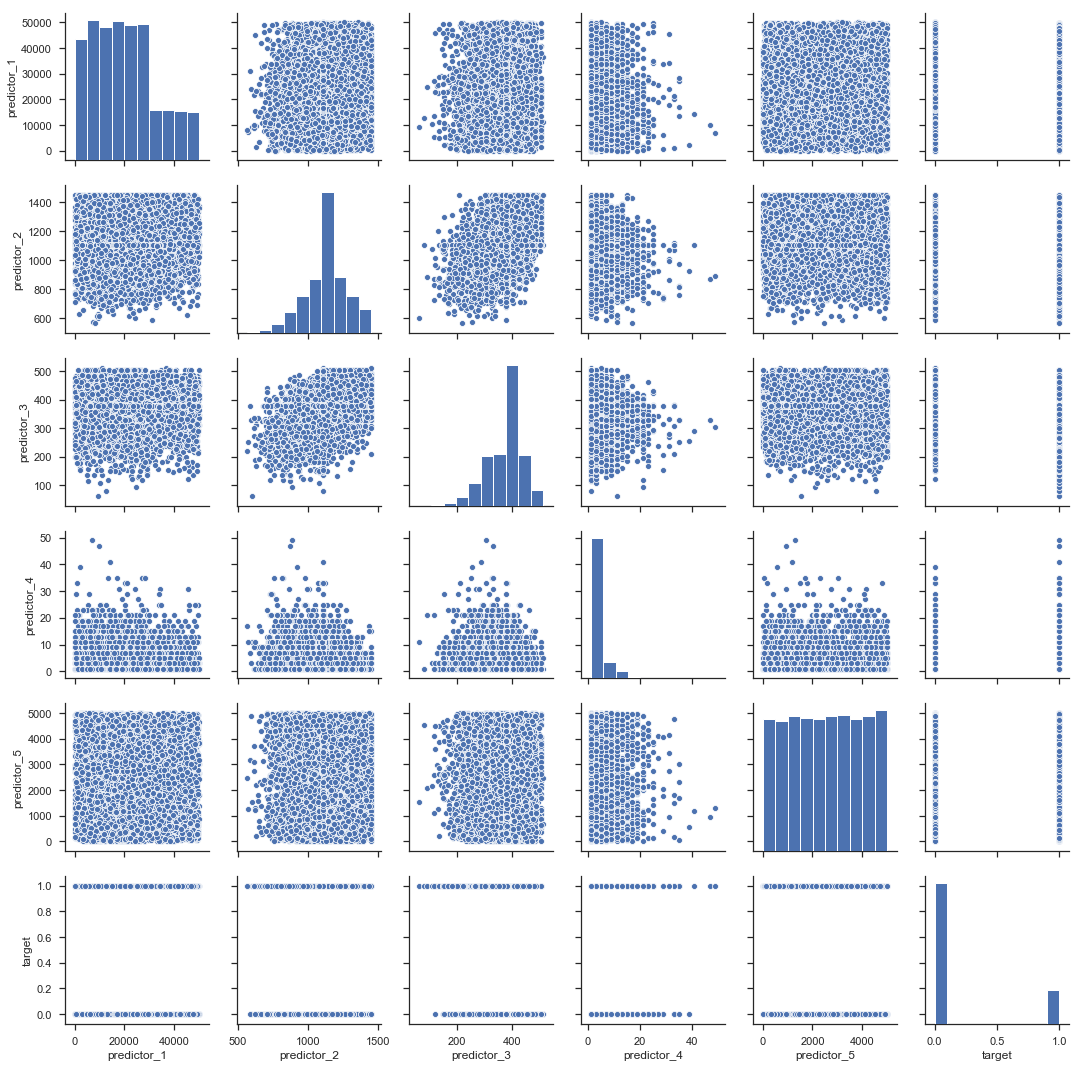

In [11]:
# Нарисуем попарные графики фичей
sns.set(style="ticks", color_codes=True)
sns_plot = sns.pairplot(df)

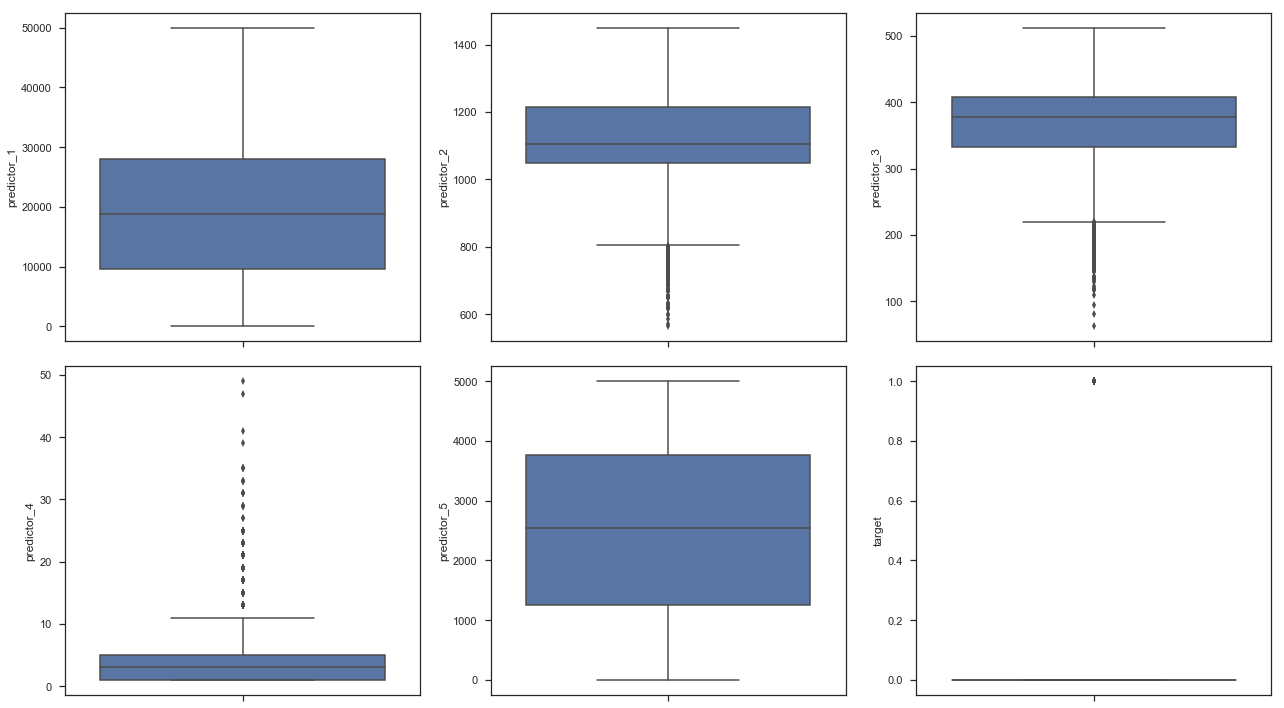

Боксплоты по переменным с разделением на таргет=1 и =0


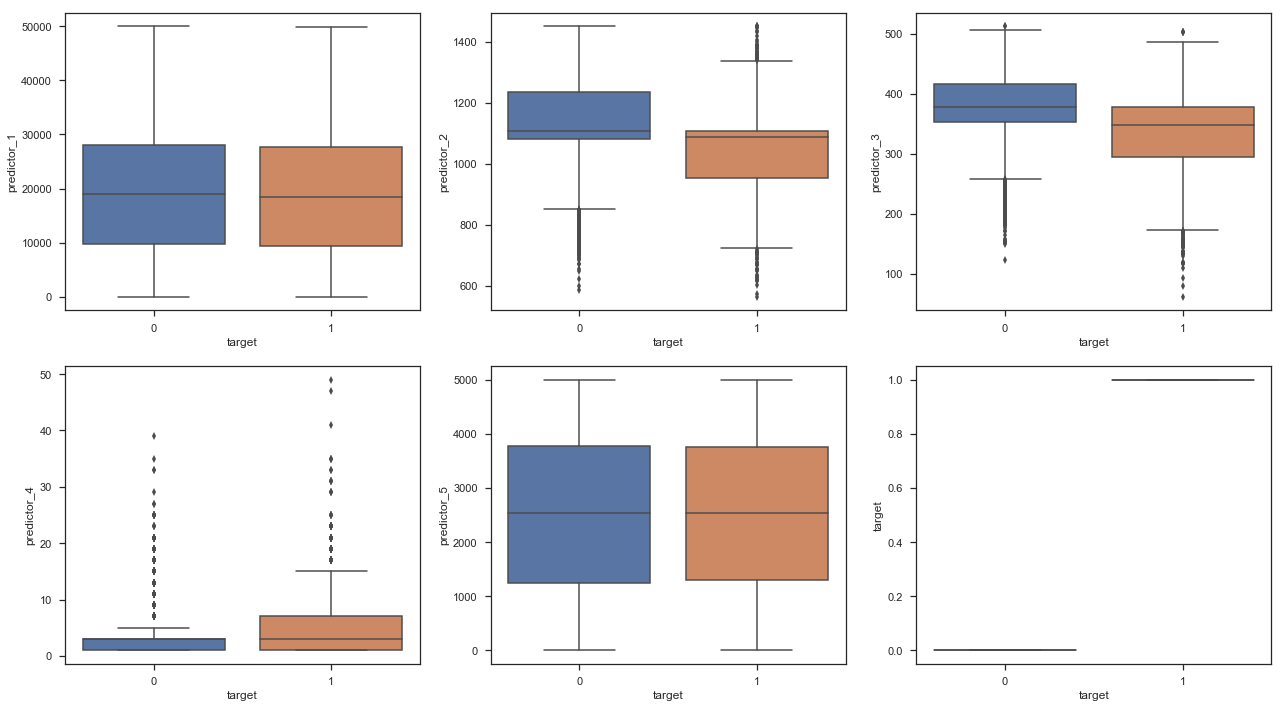

Хитмэп корреляций между переменными


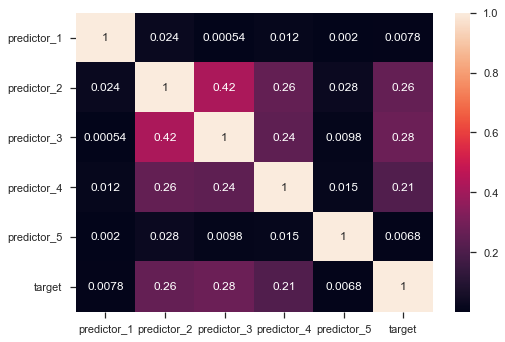

In [12]:
# Нарисуем боксплоты по переменным
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(y= df.iloc[:, i], orient='v' , ax=ax)
fig.tight_layout();
plt.show();
print('Боксплоты по переменным с разделением на таргет=1 и =0')
# Нарисуем боксплоты по переменным с разделением на таргет=1 и =0
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(y= df.iloc[:, i], x=df['target'],  orient='v' , ax=ax)
fig.tight_layout();
plt.show();
# Построим хитмэп корреляций между переменными
print('Хитмэп корреляций между переменными')
sns.heatmap(abs(df.corr()), annot=True);

Поисследовав переменные пришел к выводу, что predictor 2 – это возраст клиента. Разделив на 
30 получаем, что минимум = 18, среднее=36.0, а максимум =48, количество уникальных значений 31

Анализируя боксплоты, видно, что в переменных predictor 2, 3, 4 достаточно много выбросов.
Второй трогать не будем, тк это категориальная переменная. В predictor 3 выбросы в сторону минимума, заменим на 0.03 квартиль, а в predictor 4 в сторону максимума заменим на 0.95 квартиль.

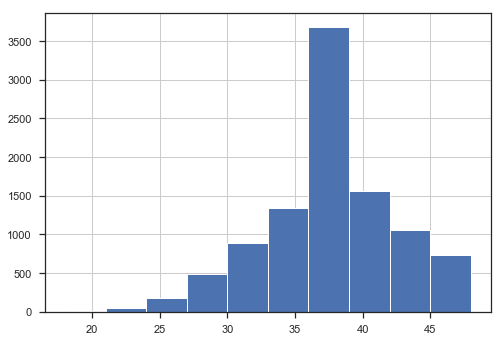

In [13]:
(df['predictor_2'] // 30).hist()

In [14]:
# Заменим predictor 2 на predictor 2 // 30 
df['predictor_2'] = df['predictor_2'] // 30

print('минимум', df['predictor_2'].min(), 'среднее', df['predictor_2'].median(), 'максимум', df['predictor_2'].max())
print('количество уникальных значений', df['predictor_2'].nunique())

минимум 18 среднее 36.0 максимум 48
количество уникальных значений 31


In [15]:
# Уберем выбросы
df['predictor_3'][df['predictor_3'] < np.quantile(df['predictor_3'], 0.03)] = np.quantile(df['predictor_3'], 0.03)
df['predictor_4'][df['predictor_4'] > np.quantile(df['predictor_4'], 0.95)] = np.quantile(df['predictor_4'], 0.95)

In [16]:
# Создадим группировки по переменным и посмотрим статистику распределения таргета по ним
for i in df.columns[:5].tolist():
    df[str('cat_')+i] = pd.cut(df[i], 6, include_lowest=False).astype('object')
    
for i in  df.columns[-5:]:
    k = df.groupby(i)['target'].agg({'sum', 'count'}).reset_index()
    k['share'] = round(k['sum'] / k['count'], 2)
    k.columns = i, 'Кол-во в группе', 'Кол-во таргета', 'Доля таргета'
    print(k,'\n')

      cat_predictor_1  Кол-во в группе  Кол-во таргета  Доля таргета
0   (-42.989, 8338.5]             2116             436          0.21
1   (8338.5, 16670.0]             2299             455          0.20
2  (16670.0, 25001.5]             2252             416          0.18
3  (25001.5, 33333.0]             1686             330          0.20
4  (33333.0, 41664.5]              851             171          0.20
5  (41664.5, 49996.0]              796             147          0.18 

  cat_predictor_2  Кол-во в группе  Кол-во таргета  Доля таргета
0   (17.97, 23.0]               55              31          0.56
1    (23.0, 28.0]              472             213          0.45
2    (28.0, 33.0]             1489             484          0.33
3    (33.0, 38.0]             4624             931          0.20
4    (38.0, 43.0]             2340             245          0.10
5    (43.0, 48.0]             1020              51          0.05 

      cat_predictor_3  Кол-во в группе  Кол-во таргета  До

### Построим Baseline

In [17]:
# Разобьем датасет стратефицировано на трейн и тест
d_train, d_test, y_train, y_test = train_test(df[df.columns[:6]])
# Нормируем значения переменных 
d_train, d_test = norm(d_train, d_test)

Доля дефолтов в тесте составляет 19 %
Доля дефолтов в трейне составляет 19 %
Размер Train 8000
Размер Test 2000


Train:
ROC AUC: 0.7317
Test:
ROC AUC: 0.7340
Лучшие параметры:  {'C': 0.01, 'penalty': 'l2', 'tol': 0.001}
intercept = [-1.45611372]  коэфициенты =  [[ 0.00312383 -0.38378244 -0.40386611  0.23815788  0.00580817]]


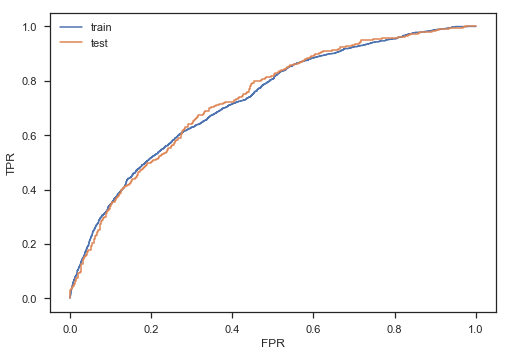

In [18]:
#Построим логистическую регрессию и сразу запустим поиск параметров с помощью GridSearch
y_train, y_pred_train, y_test, y_pred_test, lr = log_reg(d_train, y_train, d_test, y_test)

### Попробуем улучшить результаты

#### 1 ) Новая модель
Попробуем улучшить результат с помощью Random Forest.

{'max_depth': 5, 'n_estimators': 20}
Train:
ROC AUC: 0.7601
Test:
ROC AUC: 0.7267


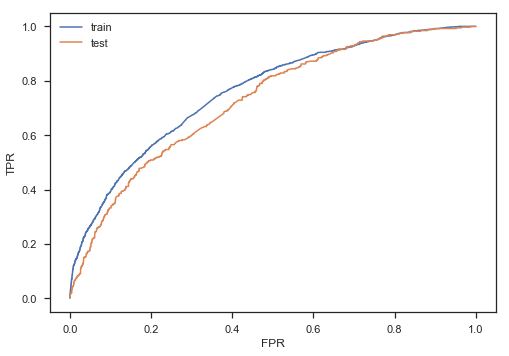

In [19]:
parameters = {
            'max_depth': [1, 2, 5, 10, 20, 100],
            'n_estimators': [1, 5, 10, 20, 50, 100]}
rfc = RandomForestClassifier(random_state=42)
clfR = GridSearchCV(rfc, parameters)
clfR.fit(d_train, y_train)
print(clfR.best_params_)
y_pred_clf_test = clfR.predict_proba(d_test)[:, 1]
y_pred_clf_train = clfR.predict_proba(d_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_clf_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_clf_test, 'test')
plt.legend();

#### 2) Герерация фичей
Подход 1 Строим полиномиальные признаки со 2 степенью.

Train:
ROC AUC: 0.7345
Test:
ROC AUC: 0.7342
Лучшие параметры:  {'C': 0.01, 'penalty': 'l1', 'tol': 0.001}
intercept = [-1.24463948]  коэфициенты =  [[-0.21284037  0.         -0.37868216 -0.38926247  0.13294779  0.
   0.          0.          0.          0.          0.         -0.02980874
   0.          0.          0.          0.          0.          0.
   0.04636921  0.         -0.03813919]]


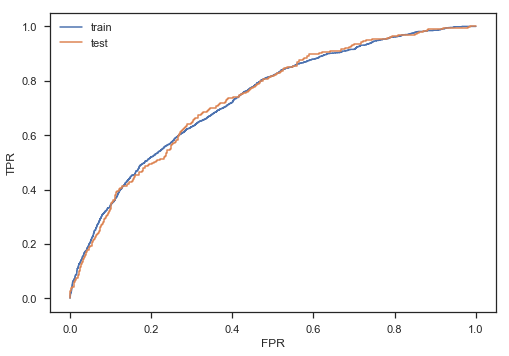

In [20]:
# попробуем улучшить результаты с помощью полиномиальных признаков во второй степени.
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
poly.fit(d_train)
daa_train = pd.DataFrame(poly.transform(d_train), columns = poly.get_feature_names(d_train.columns))
daa_test = pd.DataFrame(poly.transform(d_test), columns = poly.get_feature_names(d_train.columns))

#Построим логистическую регрессию и сразу запустим поиск параметров с помощью GridSearch
y_train, y_pred_train, y_test, y_pred_test, lr = log_reg(daa_train, y_train, daa_test, y_test)

In [21]:
imp = pd.DataFrame([daa_train.columns, lr.coef_[0]]).T
imp.columns = 'feature', 'score'
imp_vals = imp[imp['score']!=0].sort_values(by='score', ascending=False)
imp = imp_vals['feature'].tolist()
imp

['predictor_4',
 'predictor_4^2',
 'predictor_2^2',
 'predictor_5^2',
 '1',
 'predictor_2',
 'predictor_3']

Train:
ROC AUC: 0.7344
Test:
ROC AUC: 0.7334
Лучшие параметры:  {'C': 0.1, 'penalty': 'l2', 'tol': 0.1}
intercept = [-1.52849038]  коэфициенты =  [[ 0.16889261  0.06149614 -0.08785805 -0.05970355 -0.48978097 -0.46604708]]


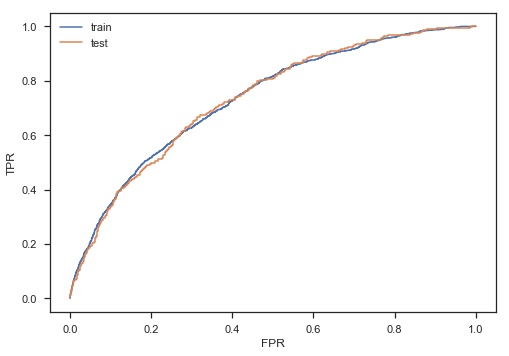

In [22]:
imp.remove('1')
y_train, y_pred_train, y_test, y_pred_test, lr = log_reg(daa_train[imp], y_train, daa_test[imp], y_test)

In [23]:
model_summary(lr, daa_train[imp], y_train, daa_train[imp].columns)

,Коэфициент,Стандартная ошибка,t критерий,P_value
Intercept,-1.528,0.009,-165.328,0.0
predictor_4,0.169,0.008,20.822,0.0
predictor_4^2,0.061,0.005,13.235,0.0
predictor_2^2,-0.088,0.003,-26.919,0.0
predictor_5^2,-0.060,0.005,-10.988,0.0
predictor_2,-0.490,0.005,-90.129,0.0
predictor_3,-0.466,0.005,-85.419,0.0


Все коэфициенты значимы.

In [24]:
report = classification_report(y_train, np.where(y_pred_train[:,1]>0.2,1,0), target_names=['class 0', 'class 1'])
print(report)

report = classification_report(y_test, np.where(y_pred_test[:,1]>0.2,1,0), target_names=['class 0', 'class 1'])
print(report)

             precision    recall  f1-score   support

    class 0       0.89      0.71      0.79      6436
    class 1       0.34      0.62      0.44      1564

avg / total       0.78      0.69      0.72      8000

             precision    recall  f1-score   support

    class 0       0.89      0.70      0.78      1609
    class 1       0.34      0.65      0.45       391

avg / total       0.78      0.69      0.72      2000



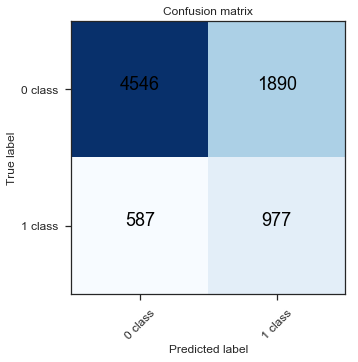

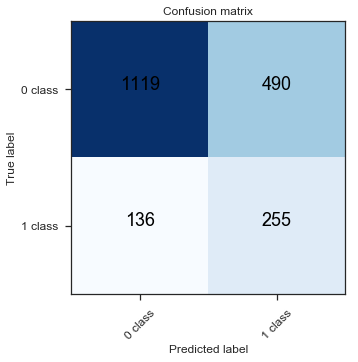

In [25]:
cnf_matrix = confusion_matrix(y_train, np.where(y_pred_train[:,1]>0.2,1,0))
plt.figure(figsize=(8, 5))
plot_confusion_matrix(cnf_matrix, classes=['0 class', '1 class'])
plt.show();
cnf_matrix = confusion_matrix(y_test, np.where(y_pred_test[:,1]>0.2,1,0))
plt.figure(figsize=(8, 5))
plot_confusion_matrix(cnf_matrix, classes=['0 class', '1 class'])
plt.show();

При трешхолде 0.2 находим 70% единичек

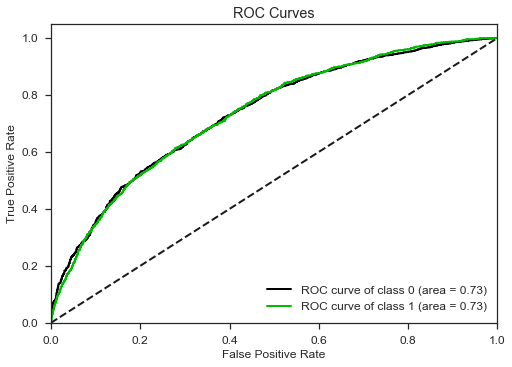

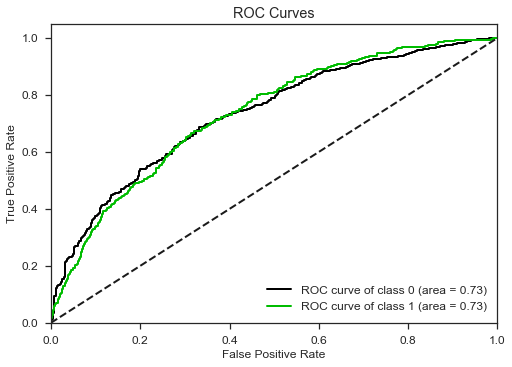

In [26]:
skplt.metrics.plot_roc_curve(y_train, y_pred_train, curves='each_class');
skplt.metrics.plot_roc_curve(y_test, y_pred_test, curves='each_class')

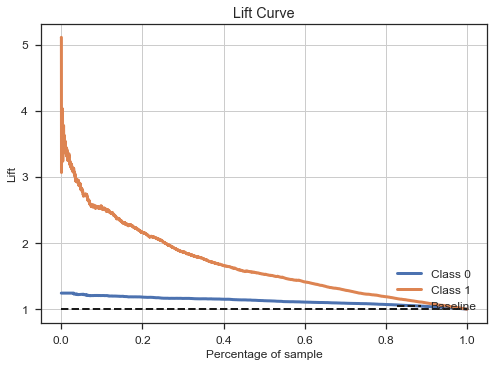

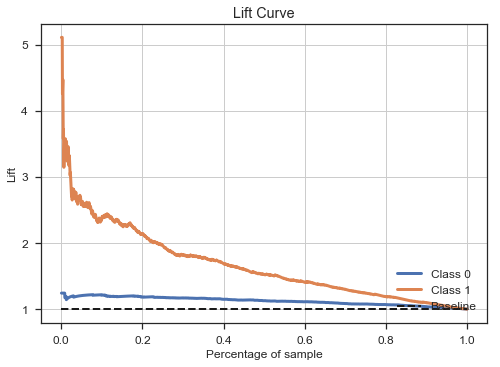

In [27]:
skplt.metrics.plot_lift_curve(y_train, y_pred_train);
skplt.metrics.plot_lift_curve(y_test, y_pred_test);

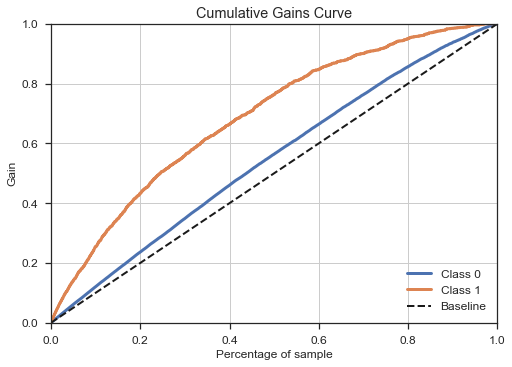

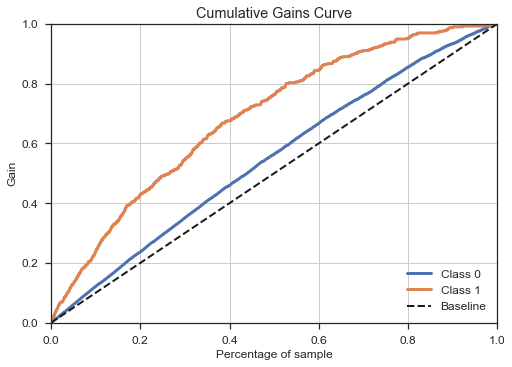

In [28]:
skplt.metrics.plot_cumulative_gain(y_train, y_pred_train);
skplt.metrics.plot_cumulative_gain(y_test, y_pred_test);

#### Подход 2 
Создаем  WOE переменные
Делаем бинизацию предикторов, разбивая их на группы. И считаем  WOE по группам, добавляем эти данные в модель 

In [29]:
# Разобьем датасет стратефицировано на трейн и тест
d_train, d_test, y_train, y_test = train_test(df, del_target=False)
cat_columns = [col for col in df.columns if df[col].dtype == 'object']
# Создаем WOE переменные
for categorical_columns in cat_columns:
    d_train, d_test = get_woe_v1(d_train, d_test, categorical_columns, 'target')
    
d_train=d_train.drop(cat_columns,axis=1)
d_test=d_test.drop(cat_columns,axis=1)
del d_train['target'], d_test['target']

# Нормируем значения переменных 
d_train, d_test = norm(d_train, d_test)

Доля дефолтов в тесте составляет 19 %
Доля дефолтов в трейне составляет 19 %
Размер Train 8000
Размер Test 2000


Train:
ROC AUC: 0.7343
Test:
ROC AUC: 0.7304
Лучшие параметры:  {'C': 0.1, 'penalty': 'l1', 'tol': 0.001}


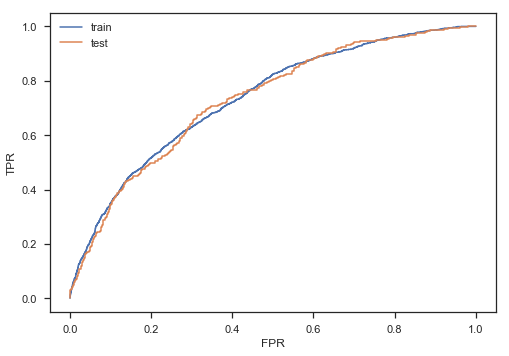

In [30]:
#Построим логистическую регрессию и сразу запустим поиск параметров с помощью GridSearch
y_train, y_pred_train, y_test, y_pred_test, lr = log_reg(d_train, y_train, d_test, y_test, print_coef=False)

Train:
ROC AUC: 0.7278
Test:
ROC AUC: 0.7198
Лучшие параметры:  {'C': 0.01, 'penalty': 'l2', 'tol': 0.001}


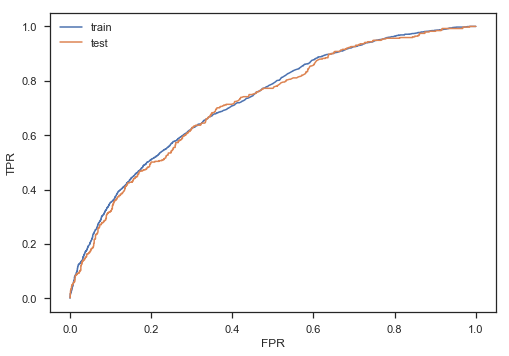

In [31]:
d_train = d_train[d_train.columns[5:]]
d_test = d_test[d_test.columns[5:]]
#Построим логистическую регрессию и сразу запустим поиск параметров с помощью GridSearch
y_train, y_pred_train, y_test, y_pred_test, lr = log_reg(d_train, y_train, d_test, y_test, print_coef=False)

#### Подход 4
Соединяем групповые предикторы. Например значение predictor 1  вместе со значением predictor 2. 

In [32]:
df['p1+p2'] = df['cat_predictor_1'].astype(str) + df['cat_predictor_2'].astype(str)
df['p1+p3'] = df['cat_predictor_1'].astype(str) + df['cat_predictor_3'].astype(str)
df['p1+p4'] = df['cat_predictor_1'].astype(str) + df['cat_predictor_4'].astype(str)
df['p1+p5'] = df['cat_predictor_1'].astype(str) + df['cat_predictor_5'].astype(str)
df['p2+p3'] = df['cat_predictor_2'].astype(str) + df['cat_predictor_3'].astype(str)
df['p2+p3'] = df['cat_predictor_2'].astype(str) + df['cat_predictor_4'].astype(str)
df['p2+p5'] = df['cat_predictor_2'].astype(str) + df['cat_predictor_5'].astype(str)
df['p3+p4'] = df['cat_predictor_3'].astype(str) + df['cat_predictor_4'].astype(str)
df['p3+p5'] = df['cat_predictor_3'].astype(str) + df['cat_predictor_5'].astype(str)
df['p4+p5'] = df['cat_predictor_4'].astype(str) + df['cat_predictor_5'].astype(str)
df['p1+p2+p3'] = df['p1+p2'].astype(str) + df['cat_predictor_3'].astype(str)
df['p2+p3+p4'] = df['p2+p3'].astype(str) + df['cat_predictor_4'].astype(str)
df['p3+p4+p5'] = df['p3+p4'].astype(str) + df['cat_predictor_5'].astype(str)
df['p1+p3+p5'] = df['p1+p3'].astype(str) + df['cat_predictor_5'].astype(str)

In [33]:
df.head(3)

,predictor_1,predictor_2,predictor_3,predictor_4,predictor_5,target,cat_predictor_1,cat_predictor_2,cat_predictor_3,cat_predictor_4,...,p1+p5,p2+p3,p2+p5,p3+p4,p3+p5,p4+p5,p1+p2+p3,p2+p3+p4,p3+p4+p5,p1+p3+p5
0,12423,23,441.5,5,4631.0,1,"(8338.5, 16670.0]","(17.97, 23.0]","(420.167, 466.333]","(4.333, 6.0]",...,"(8338.5, 16670.0](4166.75, 5000.0]","(17.97, 23.0](4.333, 6.0]","(17.97, 23.0](4166.75, 5000.0]","(420.167, 466.333](4.333, 6.0]","(420.167, 466.333](4166.75, 5000.0]","(4.333, 6.0](4166.75, 5000.0]","(8338.5, 16670.0](17.97, 23.0](420.167, 466.333]","(17.97, 23.0](4.333, 6.0](4.333, 6.0]","(420.167, 466.333](4.333, 6.0](4166.75, 5000.0]","(8338.5, 16670.0](420.167, 466.333](4166.75, 5..."
1,13983,36,377.5,3,4256.0,1,"(8338.5, 16670.0]","(33.0, 38.0]","(374.0, 420.167]","(2.667, 4.333]",...,"(8338.5, 16670.0](4166.75, 5000.0]","(33.0, 38.0](2.667, 4.333]","(33.0, 38.0](4166.75, 5000.0]","(374.0, 420.167](2.667, 4.333]","(374.0, 420.167](4166.75, 5000.0]","(2.667, 4.333](4166.75, 5000.0]","(8338.5, 16670.0](33.0, 38.0](374.0, 420.167]","(33.0, 38.0](2.667, 4.333](2.667, 4.333]","(374.0, 420.167](2.667, 4.333](4166.75, 5000.0]","(8338.5, 16670.0](374.0, 420.167](4166.75, 500..."
2,15520,42,391.5,1,4397.0,0,"(8338.5, 16670.0]","(38.0, 43.0]","(374.0, 420.167]","(0.99, 2.667]",...,"(8338.5, 16670.0](4166.75, 5000.0]","(38.0, 43.0](0.99, 2.667]","(38.0, 43.0](4166.75, 5000.0]","(374.0, 420.167](0.99, 2.667]","(374.0, 420.167](4166.75, 5000.0]","(0.99, 2.667](4166.75, 5000.0]","(8338.5, 16670.0](38.0, 43.0](374.0, 420.167]","(38.0, 43.0](0.99, 2.667](0.99, 2.667]","(374.0, 420.167](0.99, 2.667](4166.75, 5000.0]","(8338.5, 16670.0](374.0, 420.167](4166.75, 500..."


In [34]:
# Разобьем датасет стратефицировано на трейн и тест
d_train, d_test, y_train, y_test = train_test(df, del_target=False)
cat_columns = [col for col in df.columns if df[col].dtype == 'object']
# Создаем WOE переменные
for categorical_columns in cat_columns:
    d_train, d_test = get_woe_v1(d_train, d_test, categorical_columns, 'target')
    
d_train=d_train.drop(cat_columns,axis=1)
d_test=d_test.drop(cat_columns,axis=1)
del d_train['target'], d_test['target']

# Нормируем значения переменных 
d_train, d_test = norm(d_train, d_test)

Доля дефолтов в тесте составляет 19 %
Доля дефолтов в трейне составляет 19 %
Размер Train 8000
Размер Test 2000


In [35]:
d_train.head()

,predictor_1,predictor_2,predictor_3,predictor_4,predictor_5,cat_predictor_1_woe,cat_predictor_2_woe,cat_predictor_3_woe,cat_predictor_4_woe,cat_predictor_5_woe,...,p1+p5_woe,p2+p3_woe,p2+p5_woe,p3+p4_woe,p3+p5_woe,p4+p5_woe,p1+p2+p3_woe,p2+p3+p4_woe,p3+p4+p5_woe,p1+p3+p5_woe
0,-0.496999,-1.011573,-0.859873,-0.087758,-0.244420,-0.159678,1.158239,1.153899,-0.223297,1.426253,...,-0.224700,0.918637,1.145253,0.806873,1.660284,-0.463411,1.077138,0.918637,1.355859,0.778066
1,0.292616,-0.193541,0.105505,-0.776734,0.462367,-1.423887,0.254116,-0.121791,-0.684695,0.315284,...,-0.042527,0.069036,0.309503,-0.206618,-0.234276,-0.741167,0.126203,0.069036,-0.439878,-0.024743
2,0.362674,-1.011573,-0.355826,-0.776734,-1.492813,-1.423887,1.158239,0.238353,-0.684695,-1.159350,...,-0.657789,0.604165,0.986657,-0.238471,0.369240,-0.736990,1.283591,0.604165,0.086604,0.389049
3,-1.555460,0.624491,-0.646294,-0.776734,0.875843,0.827458,-0.761069,0.238353,-0.684695,1.042376,...,0.787667,-1.043614,-0.756264,-0.238471,0.289410,-0.535987,-0.690016,-1.043614,0.057268,0.310389
4,-1.231422,0.419983,-0.150790,-0.776734,0.489378,0.827458,-0.761069,0.238353,-0.684695,0.315284,...,0.164849,-1.043614,-0.974970,-0.238471,0.511565,-0.741167,-0.690016,-1.043614,-0.258519,0.204951


Train:
ROC AUC: 0.7678
Test:
ROC AUC: 0.7022
Лучшие параметры:  {'C': 1, 'penalty': 'l2', 'tol': 0.001}


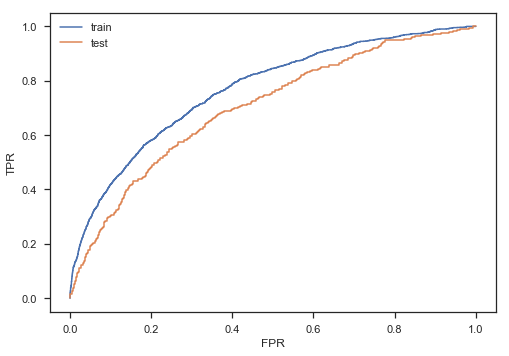

In [36]:
y_train, y_pred_train, y_test, y_pred_test, lr = log_reg(d_train, y_train, d_test, y_test, print_coef=False)

#### Подход 5
Считаем статистики  sum, count, min, max,std,var . Пример: группируем по категориальной (бининной переменной) и считаем статистики по каждому из предикторов. В Итоге XXXX новых переменных. 


In [37]:
for pred in ['cat_predictor_1', 'cat_predictor_2', 'cat_predictor_3', 'cat_predictor_4', 'cat_predictor_5']:
    for i in df.columns[:5]:
        z = df.groupby(pred)[i].agg({'sum', 'count', 'min', 'max', 'mean', 'std', 'var'}).reset_index()
        z.columns = [z.columns[0]] + [str(pred) + '_' +str(i) + '_' + k for k in z.columns[1:]]
        df = df.merge(z, how='left', on=pred)

In [38]:
# Уберем корреляции более 0.6 
df2, to_drop, to_drop_after_corr = drop_corr_col(df, 0.6, 1)

143


In [39]:
# Разобьем датасет стратефицировано на трейн и тест
d_train, d_test, y_train, y_test = train_test(df2, del_target=False)
cat_columns = [col for col in df.columns if df[col].dtype == 'object']
# Создаем WOE переменные
for categorical_columns in cat_columns:
    d_train, d_test = get_woe_v1(d_train, d_test, categorical_columns, 'target')
    
d_train=d_train.drop(cat_columns,axis=1)
d_test=d_test.drop(cat_columns,axis=1)
del d_train['target'], d_test['target']

# Нормируем значения переменных 
d_train, d_test = norm(d_train, d_test)

Доля дефолтов в тесте составляет 19 %
Доля дефолтов в трейне составляет 19 %
Размер Train 8000
Размер Test 2000


Train:
ROC AUC: 0.7716
Test:
ROC AUC: 0.7056
Лучшие параметры:  {'C': 1, 'penalty': 'l2', 'tol': 0.1}


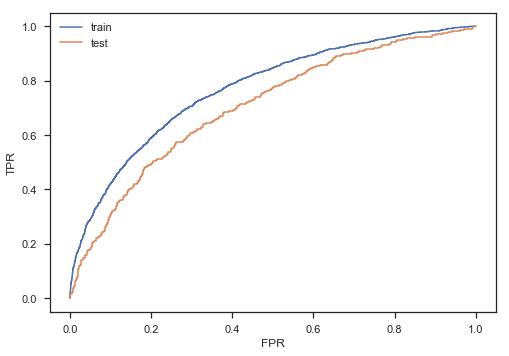

In [40]:
y_train, y_pred_train, y_test, y_pred_test, lr = log_reg(d_train, y_train, d_test, y_test, print_coef=False)

Train:
ROC AUC: 0.7997
Test:
ROC AUC: 0.7113
Количество фичей, которые важны 25


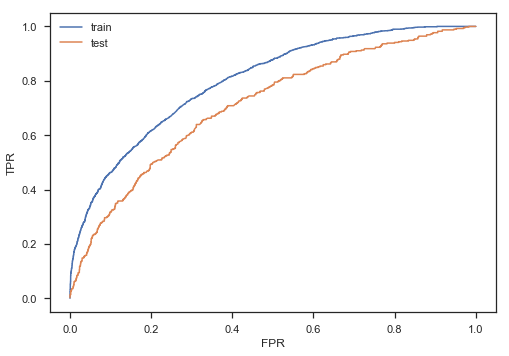

In [41]:
clf = XGBClassifier()
clf.fit(d_train, y_train)
y_pred_clf_test = clf.predict_proba(d_test)[:, 1]
y_pred_clf_train = clf.predict_proba(d_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_clf_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_clf_test, 'test')
plt.legend();

imp = pd.DataFrame([d_train.columns, clf.feature_importances_]).T
imp.columns = 'feature', 'score'
imp_vals = imp[imp['score']>0].sort_values(by='score', ascending=False)['feature'].tolist()

print('Количество фичей, которые важны', len(imp_vals))

In [42]:
imp_vals

['predictor_3',
 'p1+p3+p5_woe',
 'p3+p4+p5_woe',
 'p1+p2+p3_woe',
 'predictor_1',
 'predictor_2',
 'predictor_5',
 'p1+p4_woe',
 'p2+p3_woe',
 'p1+p5_woe',
 'p1+p2_woe',
 'p2+p5_woe',
 'p4+p5_woe',
 'cat_predictor_3_predictor_1_count',
 'cat_predictor_4_predictor_1_std',
 'p3+p5_woe',
 'p3+p4_woe',
 'cat_predictor_2_predictor_1_count',
 'predictor_4',
 'cat_predictor_4_predictor_2_min',
 'cat_predictor_5_predictor_1_std',
 'p1+p3_woe',
 'cat_predictor_1_predictor_5_max',
 'cat_predictor_5_predictor_2_std',
 'cat_predictor_1_woe']

Train:
ROC AUC: 0.7650
Test:
ROC AUC: 0.7046
Лучшие параметры:  {'C': 0.1, 'penalty': 'l2', 'tol': 0.001}


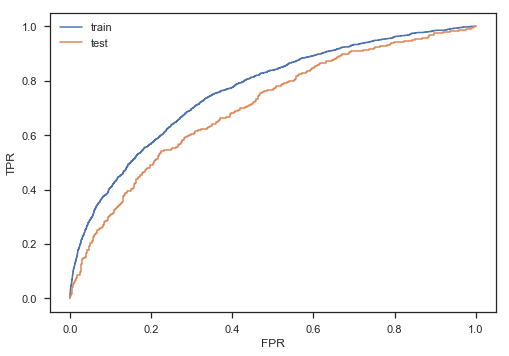

In [43]:
y_train, y_pred_train, y_test, y_pred_test, lr = log_reg(d_train[imp_vals], y_train, d_test[imp_vals], y_test, print_coef=False)

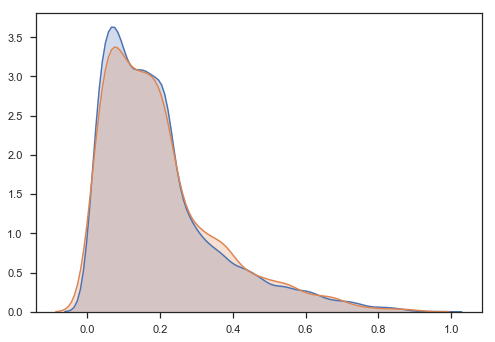

In [44]:
sns.kdeplot(y_pred_train[:, 1], shade=True);
sns.kdeplot(y_pred_test[:, 1], shade=True);

В итоге лучший подход с заданной метрикой качества AUC:

Логистическая регрессия с параметрами 'C': 0.01, 'penalty': 'l1', 'tol': 0.001
и полиномиальными признаками показывает
Train ROC AUC: 0.7345     Test ROC AUC: 0.7342
 
Переменные и коэффициенты: 
0.133 * predictor_4   0.046 * predictor_4^2 - 0.040 * predictor_2^2 - 0.038 * predictor_5^2 - 0.212 - 0.378 * predictor_2  - 0.389 * predictor_3

Выводы: Высокие, практически равные метрики на трейне и тесте говорят о том, что модель будет вести себя стабильно при похожем распределении переменных. Lift Curve показывает, что модель отлично находит класс 1 особенно в первых 20%. Gain говорит о том, что модель находит   ~75% всех «единичек» на 50% популяции.
Т.к. в модели участвуют предикторы со степенью, следует серьезно относиться к PSI индексу.
